Import modules/packages for leave one out cross validation (LOOCV).

In [6]:
import os
import numpy as np
from numpy import mean, std
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

Make output directory

In [7]:
cwd = os.getcwd()
path = cwd + "\output"
if not os.path.exists(path):
    os.mkdir(path)

Load data and assign response (y) and predictor (X) variables. 

In [8]:
#change file name (down20GSE26400ROC.txt) as needed
#file should contain ranking scores (e.g., T-score, NES, etc.) for items
#file must have column headers (1 for experimental and 0 for control samples) in row 1
#file must have row headers (gene or pathway IDs) in column A
df = pd.read_csv('GSE49996genedataneg.txt', delimiter = "\t", low_memory=False, header=None)

tempy = list(df.iloc[0])
tempy.pop(0)
y = np.array(tempy)

df = df.transpose()
df = df.reindex(df.index.drop(0)).reset_index(drop=True)
df2 = df.iloc[: , 1:]
querysize = len(df2.columns)
X = np.array(df2.values.tolist())

Assigning training and testing sets then performing LOOCV

In [9]:
loo = LeaveOneOut()
loo.get_n_splits(y)

88

In [10]:
dfprob = pd.DataFrame()
dfpredict = pd.DataFrame()
dfcoeff = pd.DataFrame()
for train_index, test_index in loo.split(y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cv = LeaveOneOut()
    
    model = LogisticRegression(solver='liblinear')
    clf = model.fit(X_train, y_train)
    temppredicted = model.predict(X_test)
    predicted = pd.Series(temppredicted)
    dfpredict = dfpredict.append(predicted, ignore_index=True)
    tempprobability = model.predict_proba(X_test)
    tempprobability = tempprobability[0]
    probability = pd.Series(tempprobability)
    dfprob = dfprob.append(probability, ignore_index=True)
    print('Probability y-axis for this sample is:')
    print(probability)
    print('Predicted experimental conditions for this sample', predicted[0])
    print('Actual experimental conditions for this sample', y_test)
    print()
    
    #returns coefficients for each gene in the logistic regression equation
    clfall = clf.coef_ 
    clfall = np.append(clfall, clf.intercept_)
    tempseries = pd.Series(clfall)
    dfcoeff = dfcoeff.append(tempseries, ignore_index=True)
    
dfpredict.to_csv('output\dfpredictdata.txt', sep='\t', index=True)
dfprob.to_csv('output\dfprobdata.txt', sep='\t', index=False)
dfcoeffavg = dfcoeff.mean(axis=0)
dfcoeffavg.to_csv('output\dfcoeffdata.txt', sep='\t', index=True)

Probability y-axis for this sample is:
0    0.99819
1    0.00181
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.219945
1    0.780055
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.992204
1    0.007796
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.867973
1    0.132027
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.99737
1    0.00263
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.999633
1    0

Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.000391
1    0.999609
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.065616
1    0.934384
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.036525
1    0.963475
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.604463
1    0.395537
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.881964
1    0.118036
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [1.]

Pr

In [11]:
#reports performance via mean (and stdev) of accurate predicted sample conditions
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
print('Accuracy mean is', np.mean(scores))
print('Accuracy stdev is', np.std(scores))

Accuracy mean is 0.8295454545454546
Accuracy stdev is 0.37603163881305224


Time to calculate the average coeff and test that equation against each sample individually

In [12]:
#calculate average coeff
coeffavgY = []
for iter in dfcoeff:
    colavg = dfcoeff[iter].mean()
    coeffavgY.append(colavg)
tempseries = pd.Series(coeffavgY)
tempseries.to_csv('output\coeffavgYdata.txt', sep='\t', index=True)

In [13]:
dfcoeffavg = pd.DataFrame()
sampleXlist = []
for iter, row in df2.iterrows():
    sampleX = 0
    i = 1
    for iter2 in tempseries.iteritems():
        if i < (len(tempseries)-1):
            sampleX = sampleX + (row[i]*iter2[1])
        else:
            sampleX = sampleX + iter2[1]
        i = i + 1
    sampleXlist.append(sampleX)

tempseries1 = pd.Series(y)
tempseries2 = pd.Series(sampleXlist)
dfcoeffavg['y'] = tempseries1
dfcoeffavg['sampleXlist'] = sampleXlist
dfcoeffavg.to_csv('output\dfcoeffavg.txt', sep='\t', index=True)

Time to visualize the results generated above

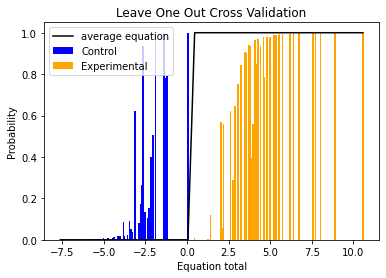

In [14]:
temparray = dfprob[1]
dfcoeffavg['probability'] = temparray
dfcoeffavg = dfcoeffavg.sort_values(by=['sampleXlist'], ascending=True)

controlXvals = []
expXvals = []
controlYvals = []
expYvals = []
for iter, row in dfcoeffavg.iterrows():
    if row[0] == 0:
        controlXvals.append(row[1])
        controlYvals.append(row[2])
    if row[0] == 1:
        expXvals.append(row[1])
        expYvals.append(row[2])

plt.title("Leave One Out Cross Validation")
plt.xlabel("Equation total")
plt.ylabel("Probability")
plt.plot(dfcoeffavg['sampleXlist'], dfcoeffavg['y'], label='average equation', color='black')
plt.bar(controlXvals, controlYvals, width=0.1, label='Control', color='blue')
plt.bar(expXvals, expYvals, width=0.1, label='Experimental', color='orange')
plt.legend(loc='best')
plt.show()

# Below is the code for LOOCVrandom model

Load data and assign response (y) and predictor (X) variables.

In [15]:
#change file name (down20GSE26400ROC.txt) as needed
#file should contain ranking scores (e.g., T-score, NES, etc.) for items (e.g. genes, pathways, etc.)
#file must have column headers (1 for experimental and 0 for control samples) in row 1
#file must have row headers (gene or pathway IDs) in column A
dfall = pd.read_csv('zscoreddata_GSE49996.txt', delimiter = "\t", low_memory=False, header=None)

tempyall = list(dfall.iloc[0])
tempyall.pop(0)
yall = np.array(tempyall)

dfall = dfall.transpose()
dfall = dfall.reindex(dfall.index.drop(0)).reset_index(drop=True)
df2all = dfall.iloc[: , 1:]
Xall = np.array(df2all.values.tolist())

Assigning training and testing sets

In [16]:
loo = LeaveOneOut()
loo.get_n_splits(yall)

88

Function to shuffle gene list and select groups of random genes for LOOCV

In [17]:
totalaccuracy = 0
perfect = 0
low = 1
dfrandomaccuracy = pd.DataFrame()

for i in range(1000):
    dfrandomsample = df2all.sample(n=querysize,axis='columns')
    Xrandomsample = np.array(dfrandomsample.values.tolist())
    for train_index, test_index in loo.split(yall):
        X_train, X_test = Xrandomsample[train_index], Xrandomsample[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        cv = LeaveOneOut()
    
        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        predicted = predicted[0]
        probability = model.predict_proba(X_test)
        probability = probability[0]
        
    scores = cross_val_score(model, dfrandomsample, y, scoring='accuracy', cv=cv)
    meanscores = np.mean(scores)
    stdevscores = np.std(scores)
    dfrandomaccuracy = dfrandomaccuracy.append({'mean':meanscores, 'stdev':stdevscores}, ignore_index=True)
    
    if mean(scores) == 1:
        perfect = perfect + 1
    if mean(scores) < low:
        low = mean(scores)

    totalaccuracy = mean(scores) + totalaccuracy
    
dfrandomaccuracy.to_csv('output\dfrandomaccuracydata.txt', sep='\t', index=True)

In [18]:
avgaccuracy = dfrandomaccuracy['mean'].mean()
stdevaccuracy = dfrandomaccuracy['stdev'].std()
print("Number of random LOOCV achieving 1.0 accuracy:", perfect)
print("Lowest random LOOCV accuracy score achieved:", low)
print("Average accuracy over", i+1, "permutations:", avgaccuracy)
print("Standard deviation of accuracy is:", stdevaccuracy)

Number of random LOOCV achieving 1.0 accuracy: 0
Lowest random LOOCV accuracy score achieved: 0.7272727272727273
Average accuracy over 1000 permutations: 0.8258409090909122
Standard deviation of accuracy is: 0.027754687579144118


Time to visualize the randomly generated results

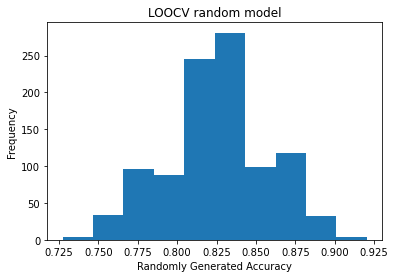

In [19]:
plt.title("LOOCV random model")
plt.xlabel("Randomly Generated Accuracy")
plt.ylabel("Frequency")
plt.hist(dfrandomaccuracy['mean'], bins=50)
plt.show()